## 05- Usos del Modelo

Existen diversas aplicaciones de negocio con el resultado u output de la herramienta analítica de churn. Debido a que esta arroja una probabilidad (0 a 1) de que un cliente no renueve su póliza. Este valor puede asumirse como una medición del grado de satisfacción del cliente con el servicio u producto obtenido. En ese orden de ideas, diversas iniciativas pueden proponerse usando como fuente la probabilidad de churn de los clientes, algunas pueden ser:

- Caracterización de clientes de mayor riesgo de churn
- Estimación del customer value en términos de su probabilidad de churn
- Campañas de fidelización de los clientes con mayor riesgo de churn
- Estrategias de renovación o venta cruzada para los clientes de menor riesgo de churn

A continuación se realiza una pequeña caracterización de la probabilidad de churn de los clientes que tomaron pólizas en Febrero de 2022.

In [1]:
from model_parameters import *
import pickle
import pandas as pd
import numpy as np
from sklearn import set_config
set_config(display='diagram')

#cargue del modelo
with open("models/xgbmodel.pickle", 'rb') as f:
    xgb = pickle.load(f)


### Cargue de data feb 2022 generada en notebook 01

In [4]:
data=pd.read_csv("polizas_feb22.csv",sep=";",dtype={'Asegurado__c':str,'NumeroPoliza__c':str,'CodigoTipoAsegurado__c':str,'churn':int,'ClaseVehiculo__c':str,'TipoVehiculo__c':str,'PuntoVenta__c':str,'MarcaVehiculo__c':str},na_values="nan")

In [16]:
##calcular probabilidad de churn
proba_churn=xgb.predict_proba(data)[:,1]
data['proba_churn']=proba_churn


### Regla de decisión
Al tener la probabilidad de churn, es necesario establecer el valor a partir del cual un cliente es considerado con alto riesgo de churn. Una alternativa es usar los quantiles de la distribución.

Percentil 25: 0.461 y 75: 0.519 


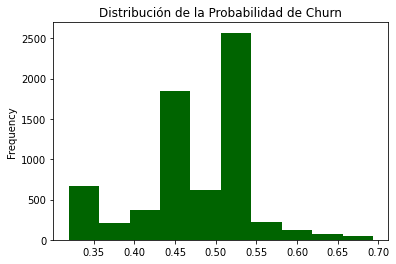

In [30]:
data.proba_churn.plot(kind="hist",title="Distribución de la Probabilidad de Churn", color="darkgreen");
print("Percentil 25: {:.3f} y 75: {:.3f} ".format(*np.quantile(proba_churn,[0.25,0.75])))


Podría decirse que, basado en la distribución de probabilidades de churn de febrero de 2022, el 25% de las probabilidades más altas empiezan a partir de `0.519`. Por tanto asumimos este valor como el punto de corte para clasificar un cliente con alta probabilidad de churn.

In [39]:
clientes_riesgo=data.query("proba_churn>0.519")
print("Total Clientes con alto riesgo de churn: {}".format(clientes_riesgo.shape[0]))

Total Clientes con alto riesgo de churn: 2588


### Analicemos estos clientes

<AxesSubplot:ylabel='Frequency'>

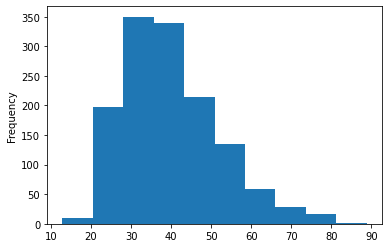

In [51]:
clientes_riesgo.edad.plot(kind="hist")

In [66]:
print("===Caracterización Clientes con Mayor Riesgo de Churn===\n\n \t *Características Cualitativas*")

for col in ['ciudad_name','tipo_prod_desc','EstadoCivil__pc','Genero__pc']:
    print(f"\n \tVariable: {col} \t\n")
    print(clientes_riesgo[col].value_counts(sort=True))

print("\n\t *Características Numéricas*")
for col in ['total_siniestros','edad','AnnualRevenue']:
    value=clientes_riesgo[col].median() if col !="AnnualRevenue" else clientes_riesgo[col].median()/(12*1000000)
    print(f"\n Variable: {col} Valor Mediano: {value:.2f} \t\n")

===Caracterización Clientes con Mayor Riesgo de Churn===

 	 *Características Cualitativas*

 	Variable: ciudad_name 	

otras            1266
BOGOTÁ D.C.        40
MEDELLIN           15
CALI                8
ARMENIA             7
NEIVA               7
CÚCUTA              6
BUCARAMANGA         5
TULUÁ               4
FLORENCIA           4
PEREIRA             4
MANIZALES           3
PASTO               3
POPAYÁN             3
VILLAVICENCIO       3
IBAGUÉ              1
AGUA DE DIOS        1
BARRANQUILLA        1
Name: ciudad_name, dtype: int64

 	Variable: tipo_prod_desc 	

extracontractual         1290
automoviles               994
profesionales medicos     242
operadores portuarios      46
otras                      16
Name: tipo_prod_desc, dtype: int64

 	Variable: EstadoCivil__pc 	

SOLTERO       875
CASADO        330
OTRO          128
N A            23
UNIDO          21
DIVORCIADO      4
Name: EstadoCivil__pc, dtype: int64

 	Variable: Genero__pc 	

MASCULINO    1032
FEMENINO      3

## Conclusiones

Una posible caracterización de los clientes con mayor riesgo de churn, son los `hombres solteros que contratan pólizas tipo extracontractual`, que no viven en ciudades principales cercanos a los `38 años` con ingresos medios de `3.3 SMMLV` y que han tenido al menos `un siniestro previamente`.

In [67]:
##exportar data de clientes

clientes_riesgo.to_csv("clientes_riesgofeb22.csv",sep=";",index=False)